In [4]:
import pyopia.background
import pyopia.classify
import pyopia.instrument.silcam
import pyopia.instrument.holo
import pyopia.io
import pyopia.pipeline
import pyopia.plotting
import pyopia.process
import pyopia.statistics
import exampledata

import xarray
import matplotlib.pyplot as plt

## Load a TOML config file containing all setttings, and pipeline steps

This creates a dict of all settings

In [5]:
toml_settings = pyopia.io.load_toml('config.toml')
toml_settings

{'steps': {'classifier': {'pipeline_class': 'pyopia.classify.Classify',
   'model_path': 'keras_model.h5'},
  'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
  'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
   'image_level': 'imraw'},
  'segmentation': {'pipeline_class': 'pyopia.process.Segment',
   'threshold': 0.85},
  'statextract': {'pipeline_class': 'pyopia.process.CalculateStats'}}}

## Make the steps dict

This is the dict that is given to `pyopia.pipeline.Pipeline`

The dict created here is not human-readable (but that shouldn't matter, since this came from the human-readable TOML config)

We are not including the disc writing in the pipeline for this example - so we can better demonstrate the formatted output data

In [6]:
steps = pyopia.pipeline.build_steps(toml_settings['steps'])
steps

{'classifier': <pyopia.classify.Classify at 0x237bc2babf0>,
 'load': <pyopia.instrument.silcam.SilCamLoad at 0x237c2818550>,
 'imageprep': <pyopia.instrument.silcam.ImagePrep at 0x237c2e437f0>,
 'segmentation': <pyopia.process.Segment at 0x237c2e43880>,
 'statextract': <pyopia.process.CalculateStats at 0x237c12523b0>}

## Run the pipeline

(same as normal)

In [7]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(steps)

# Load an image (from the test suite)
filename = exampledata.get_example_silc_image()

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
  Running <pyopia.classify.Classify object at 0x00000237BC2BABF0>
Pipeline ready with these data:  ['cl']
calling:  <class 'pyopia.instrument.silcam.SilCamLoad'>  with:  ['cl', 'filename', 'steps_string']
calling:  <class 'pyopia.instrument.silcam.ImagePrep'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw']
calling:  <class 'pyopia.process.Segment'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw', 'imref', 'imc']
segment
clean
calling:  <class 'pyopia.process.CalculateStats'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw', 'imref', 'imc', 'imbw']
statextract
21.7% saturation
measure
  870 particles found
WARNING. exportparticles temporarily modified for 2-d images without color!
EXTRACTING 870 IMAGES from 870


## Write to disc

We will convert the STATS DataFrame into xarray for efficiency and easier metadata handling and easy writing to NetCDF.

This will use the steps part of the TOML configuration as metadata (attribute)

In [8]:
pyopia.io.write_stats(
        'proc/test',
        stats,
        steps_string=toml_settings['steps'],
        append=False,
        format='nc')

## Load the data again

Then later, we can load the data again from NetCDF using xarray

xarray DataSets are presented nicely in notebooks

In [9]:
xstats = xarray.open_dataset('proc/test-STATS.nc')
xstats

<xarray.Dataset>
Dimensions:                     (index: 870)
Coordinates:
  * index                       (index) int32 0 1 2 3 4 ... 865 866 867 868 869
    time                        (index) datetime64[ns] ...
Data variables: (12/17)
    export name                 (index) object ...
    major_axis_length           (index) float64 ...
    minor_axis_length           (index) float64 ...
    equivalent_diameter         (index) float64 ...
    minr                        (index) float64 ...
    minc                        (index) float64 ...
    ...                          ...
    probability_faecal_pellets  (index) float64 ...
    probability_copepod         (index) float64 ...
    probability_diatom_chain    (index) float64 ...
    probability_oily_gas        (index) float64 ...
    timestamp                   (index) datetime64[ns] ...
    saturation                  (index) float64 ...
Attributes:
    steps:           [classifier]\npipeline_class = "pyopia.classify.Classify...
    Modified:        2023-07-06 14:08:48.761690
    PyOpia version:  0.0.53

## Alter settings and re-process

What if we wanted to re-process this dataset with a different segmentation threshold?

### Get the TOML steps from the xarray DataSet

In [10]:
toml_steps = pyopia.pipeline.steps_from_xstats(xstats)
toml_steps

{'classifier': {'pipeline_class': 'pyopia.classify.Classify',
  'model_path': 'keras_model.h5'},
 'load': {'pipeline_class': 'pyopia.instrument.silcam.SilCamLoad'},
 'imageprep': {'pipeline_class': 'pyopia.instrument.silcam.ImagePrep',
  'image_level': 'imraw'},
 'segmentation': {'pipeline_class': 'pyopia.process.Segment',
  'threshold': 0.85},
 'statextract': {'pipeline_class': 'pyopia.process.CalculateStats'}}

### Alter the setting we want to change

In [11]:
toml_steps['segmentation']['threshold'] = 0.9

### re-build the pipeline steps

In [12]:
steps = pyopia.pipeline.build_steps(toml_steps)
steps

{'classifier': <pyopia.classify.Classify at 0x237c38afc70>,
 'load': <pyopia.instrument.silcam.SilCamLoad at 0x237c38e8b80>,
 'imageprep': <pyopia.instrument.silcam.ImagePrep at 0x237c38e8b50>,
 'segmentation': <pyopia.process.Segment at 0x237c38e8e50>,
 'statextract': <pyopia.process.CalculateStats at 0x237c38e7520>}

### re-process the pipeline

In [13]:
# Initialise the pipeline and run the initial steps
processing_pipeline = pyopia.pipeline.Pipeline(steps)

# Load an image (from the test suite)
filename = exampledata.get_example_silc_image()

# Process the image to obtain the stats dataframe
stats = processing_pipeline.run(filename)

Initialising pipeline
  Running <pyopia.classify.Classify object at 0x00000237C38AFC70>
Pipeline ready with these data:  ['cl']
calling:  <class 'pyopia.instrument.silcam.SilCamLoad'>  with:  ['cl', 'filename', 'steps_string']
calling:  <class 'pyopia.instrument.silcam.ImagePrep'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw']
calling:  <class 'pyopia.process.Segment'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw', 'imref', 'imc']
segment
clean
calling:  <class 'pyopia.process.CalculateStats'>  with:  ['cl', 'filename', 'steps_string', 'timestamp', 'imraw', 'imref', 'imc', 'imbw']
statextract
24.7% saturation
measure
  1223 particles found
WARNING. exportparticles temporarily modified for 2-d images without color!
EXTRACTING 1222 IMAGES from 1223


### Further analysis

At this point we could write this to disc again (like before)

and/or we could build a new, correctly formatted, xarray for immediate use (which we will do here):

In [14]:
xstats_modified = pyopia.io.make_xstats(stats, toml_steps)
xstats_modified

<xarray.Dataset>
Dimensions:                     (index: 1223)
Coordinates:
  * index                       (index) int64 0 1 2 3 4 ... 1219 1220 1221 1222
    time                        (index) datetime64[ns] 2018-11-01T14:27:31.83...
Data variables: (12/17)
    major_axis_length           (index) float64 38.64 7.369 5.033 ... 7.228 6.57
    minor_axis_length           (index) float64 35.92 4.891 ... 5.181 3.574
    equivalent_diameter         (index) float64 37.12 5.863 ... 5.971 4.514
    minr                        (index) float64 3.0 3.0 ... 2.039e+03 2.042e+03
    minc                        (index) float64 281.0 1.002e+03 ... 2.367e+03
    maxr                        (index) float64 42.0 11.0 ... 2.046e+03
    ...                          ...
    probability_copepod         (index) float64 0.002331 0.002331 ... 0.002331
    probability_diatom_chain    (index) float64 0.005164 0.005164 ... 0.005164
    probability_oily_gas        (index) float64 0.1086 0.1086 ... 0.1086 0.1086
    export name                 (index) object 'D20181101T142731.838206-PN0' ...
    timestamp                   (index) datetime64[ns] 2018-11-01T14:27:31.83...
    saturation                  (index) float64 24.65 24.65 ... 24.65 24.65
Attributes:
    steps:           [classifier]\npipeline_class = "pyopia.classify.Classify...
    Modified:        2023-07-06 14:09:03.409498
    PyOpia version:  0.0.53

### Plotting

We can plot directly from xarray in exactly the same way as from the Pandas DataFrame (so it doesn't matter which you use here). The benefit of 'xstats' as an xarray is that it now contains it's own metadata

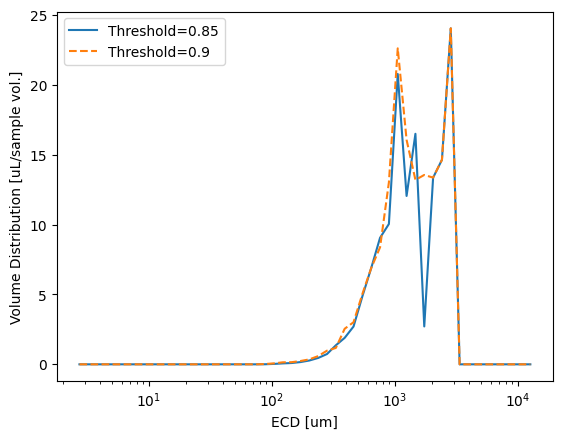

In [15]:
dias, vd = pyopia.statistics.vd_from_stats(xstats, 24)

plt.plot(dias, vd, label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats)['segmentation']['threshold']}")
plt.xscale('log')
plt.xlabel('ECD [um]')
plt.ylabel('Volume Distribution [uL/sample vol.]')

dias_modified, vd_modified = pyopia.statistics.vd_from_stats(xstats_modified, 24)

plt.plot(dias_modified, vd_modified, '--', label=f"Threshold={pyopia.pipeline.steps_from_xstats(xstats_modified)['segmentation']['threshold']}")

plt.legend()